In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
import ee
ee.Authenticate()
ee.Initialize()

In [3]:
import tensorflow as tf

print(tf.__version__)

2.2.0-rc3


In [4]:
import folium
print(folium.__version__)

0.8.3


In [0]:
BUCKET = 'andrewrenningerfinal'

In [0]:
FOLDER = 'final'
TRAINING_BASE = 'training'
EVAL_BASE = 'testing'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'impervious'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 16000
EVAL_SIZE = 8000

# Specify model training parameters.
BATCH_SIZE = 16
EPOCHS = 10
BUFFER_SIZE = 2000
OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['accuracy']

In [7]:
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
srtm = ee.Image('USGS/SRTMGL1_003')

def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000).addBands(
          image.select(thermalBands).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

image = l8sr.filterDate('2015-01-01', '2017-12-31').map(maskL8sr).median()

mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

mapid = image.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [9]:
nlcd = ee.Image('USGS/NLCD/NLCD2016').select('impervious')
nlcd = nlcd.divide(100).float()

mapid = nlcd.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='nlcd impervious',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [0]:
light = image.select(BANDS)
slope = ee.Terrain.slope(srtm) 

composite = nlcd.addBands([slope, light])

In [51]:
mapid = composite.getMapId({'bands': ['slope'], 'min': 0, 'max': 90})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map

composite = composite.float()

In [52]:
trainingPolys = ee.FeatureCollection('users/asrenninger/training')
evalPolys = ee.FeatureCollection('users/asrenninger/testing')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['#f0f0f0', '#000000']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [0]:
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

for g in range(trainingPolys.size().getInfo()):
  desc = TRAINING_BASE + '_' + str(g)
  task = ee.batch.Export.image.toCloudStorage(
    image = composite,
    fileNamePrefix = FOLDER + '/' + desc,
    description = desc, 
    bucket = BUCKET, 
    region = ee.Feature(trainingPolysList.get(g)).geometry(), 
    scale = 30, 
  )
  task.start()

In [0]:
for g in range(evalPolys.size().getInfo()):
  desc = EVAL_BASE + '_' + str(g)
  task = ee.batch.Export.image.toCloudStorage(
    image = composite,
    fileNamePrefix = FOLDER + '/' + desc,
    description = desc, 
    bucket = BUCKET, 
    region = ee.Feature(evalPolysList.get(g)).geometry(), 
    scale = 30, 
  )
  task.start()

In [4]:
!pip install tifffile

     |████████████████████████████████| 133kB 4.9MB/s 
     |████████████████████████████████| 18.1MB 195kB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/final_training_0.tif'

In [0]:
import tifffile as tiff

In [6]:
img = tiff.imread(path)
img.shape

(6410, 6690, 11)

In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

In [0]:
import matplotlib
import matplotlib.pyplot as plt

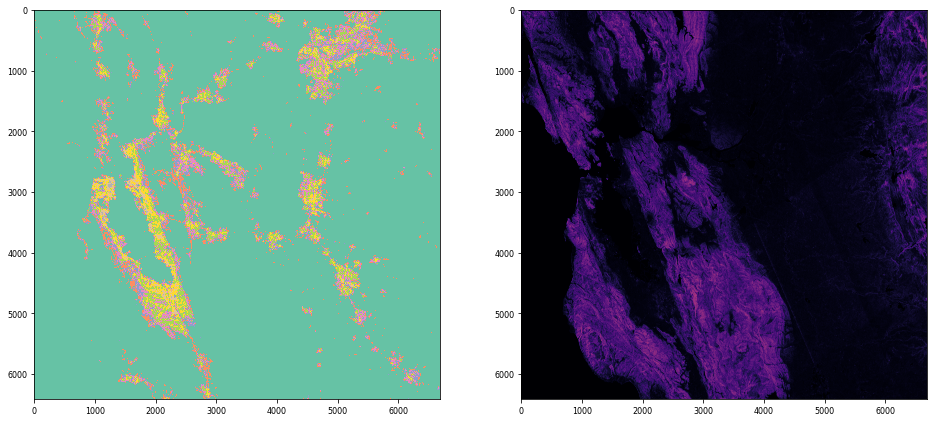

In [32]:
fig, axs = plt.subplots(1, 2, figsize = [16, 16])

axs[0].imshow(img[:, :, 0], cmap = 'Set2')
axs[1].imshow(img[:, :, 1], cmap = 'magma')

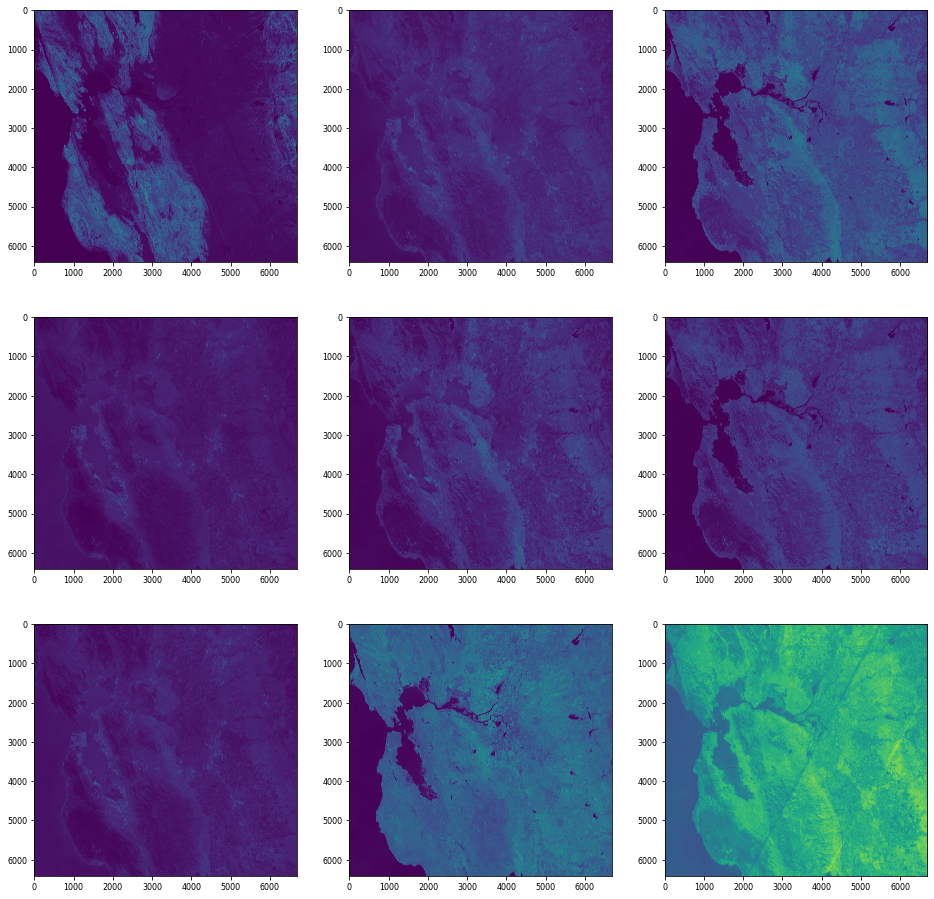

In [33]:
fig, axs = plt.subplots(3, 3, figsize = [16, 16])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = slot = i*3+j
      axs[j, i].imshow(img[:,:, slot + 1], cmap = 'viridis')
        
plt.show()

In [0]:
img = img[0:1000, 5000:6000, :]

In [12]:
resp = img[:, :, 0].flatten()

resp = resp * 100
resp = np.where(resp < 50, 0, resp)
resp = np.where(resp > 49, 1, resp)
print(resp.shape)

resp = resp.astype('uint8')

pred = np.zeros([resp.shape[0], 9])
print(pred.shape)

(1000000,)
(1000000, 9)


In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = img[:, :, i + 1]
  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

In [15]:
np.unique(resp)

array([0, 1], dtype=uint8)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [18]:
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D, AveragePooling2D

EPOCH = 20
BATCH = 32 

In [22]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(9,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 268,802
Trainable params: 268,802
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    validation_data = (X_test, y_test))

Train on 500000 samples, validate on 500000 samples
Epoch 1/10
500000/500000 [==============================] - 87s 174us/step - loss: 0.2877 - accuracy: 0.8686 - val_loss: 0.2803 - val_accuracy: 0.8710
Epoch 2/10
500000/500000 [==============================] - 84s 168us/step - loss: 0.2896 - accuracy: 0.8708 - val_loss: 0.2832 - val_accuracy: 0.8728
Epoch 3/10
500000/500000 [==============================] - 84s 168us/step - loss: 0.2921 - accuracy: 0.8710 - val_loss: 0.2870 - val_accuracy: 0.8732
Epoch 4/10
500000/500000 [==============================] - 85s 170us/step - loss: 0.2949 - accuracy: 0.8714 - val_loss: 0.2896 - val_accuracy: 0.8735
Epoch 5/10
500000/500000 [==============================] - 84s 168us/step - loss: 0.2964 - accuracy: 0.8714 - val_loss: 0.2807 - val_accuracy: 0.8743
Epoch 6/10
500000/500000 [==============================] - 83s 166us/step - loss: 0.2987 - accuracy: 0.8714 - val_loss: 0.2946 - val_accuracy: 0.8743
Epoch 7/10
500000/500000 [================

In [24]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.2884638439388275
Test accuracy:  0.8743100166320801
